In [1]:
from pylab import *
from scipy.stats import norm
import csv
from scipy import optimize
from datetime import date

## Problem 1

In [2]:
# Initial data
S = 1 # Stock price
K = 1.2 # Strike price of option
sigma = 0.5
T = 1
r = 0.03

# Black-Scholes Formula for European call option

def black_scholes(r, sigma, S, K, T):
    x = (log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*sqrt(T))
    return S*norm.cdf(x) - K*exp(-r*T)*norm.cdf(x - sigma*sqrt(T))

black_scholes = vectorize(black_scholes)

### A: Call price v. stock price

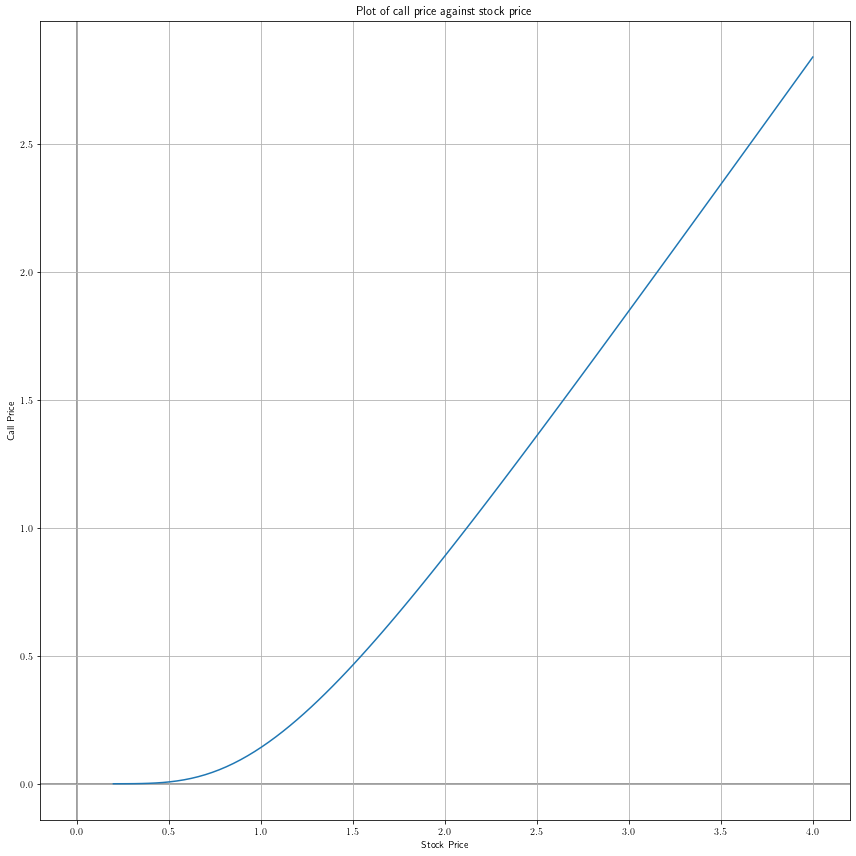

In [3]:
SS = linspace(0.2,4,100) # Array of stock prices

fig = plt.figure(figsize=(12,12))
rc('text', usetex=True)

title('Plot of call price against stock price')
plot(SS, black_scholes(r, sigma, SS, K, T))
xlabel('Stock Price')
ylabel('Call Price')
grid()
axhline(color='gray', zorder=-1)
axvline(color='gray', zorder=-1)
tight_layout()
show()

## B. Call price against interest

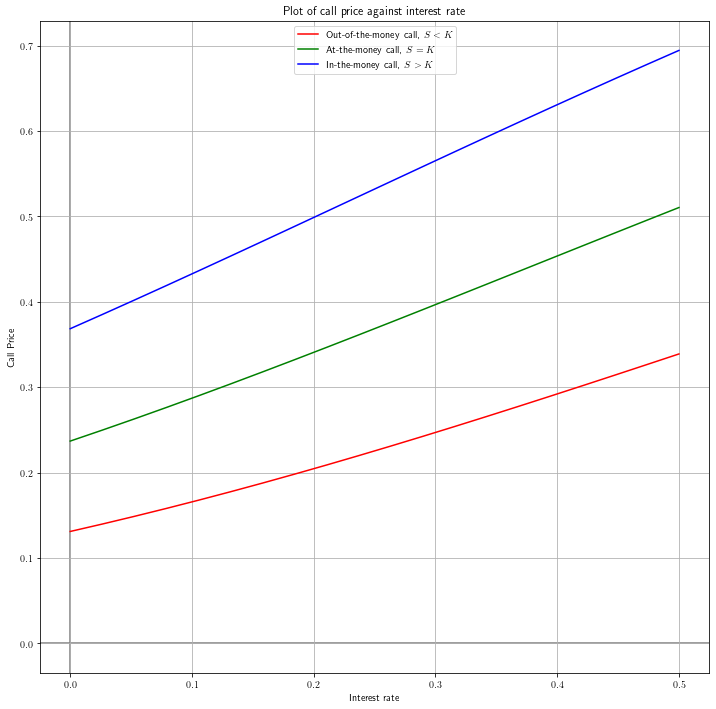

In [4]:
rr = linspace(0.0,0.5,20)

fig = plt.figure(figsize=(12,12))
rc('text', usetex=True)

title('Plot of call price against interest rate')
plot(rr, black_scholes(rr, sigma, S, K, T), 'r-', label='Out-of-the-money call, $S < K$')
plot(rr, black_scholes(rr, sigma, K, K, T), 'g-', label='At-the-money call, $S = K$')
plot(rr, black_scholes(rr, sigma, 1.4, K, T),'b-', label='In-the-money call, $S > K$')
xlabel('Interest rate')
ylabel('Call Price')
grid()
legend()
axhline(color='gray', zorder=-1)
axvline(color='gray', zorder=-1)
show()

### C. Call price against volatility

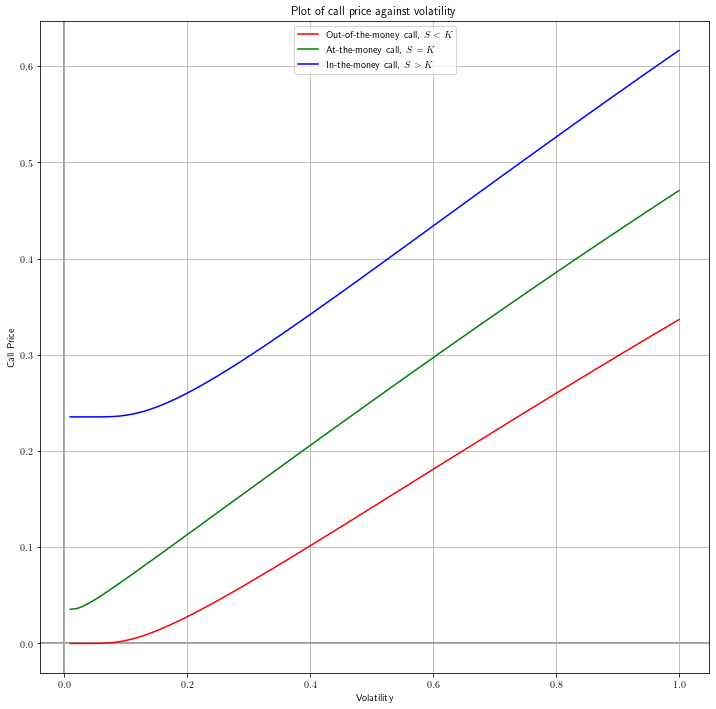

In [5]:
sigmavv = linspace(0.01,1,100)

fig = plt.figure(figsize=(12,12))
rc('text', usetex=True)

title('Plot of call price against volatility')
plot(sigmavv, black_scholes(r, sigmavv, S, K, T), 'r-', label='Out-of-the-money call, $S < K$')
plot(sigmavv, black_scholes(r, sigmavv, K, K, T), 'g-', label='At-the-money call, $S = K$')
plot(sigmavv, black_scholes(r, sigmavv, 1.4, K, T),'b-', label='In-the-money call, $S > K$')
xlabel('Volatility')
ylabel('Call Price')
grid()
legend()
axhline(color='gray', zorder=-1)
axvline(color='gray', zorder=-1)
show()

## Problem 2
Given an option price, we may use an option pricing model (e.g. the Black-Scholes formula) to backsolve for one of the inputs in the resulting implicit equation. The volatility value so obtained is termed the *implied volatility* (IV). Option implied volatilities typically exhibit a *volatility smile*; here the IV is high when the call option is out-of-the-money, then falls when at-the-money and starts to rise again when in-the-money. The CSV file for AMZN stock and call option prices was obtained [here](https://www.barchart.com/stocks/quotes/AMZN/options?expiration=2021-02-19-m) and the spot rate for zero coupon bonds was obtained [here.](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield) We use Scipy's `brentq` rootfinder to work out the implied volatilities.

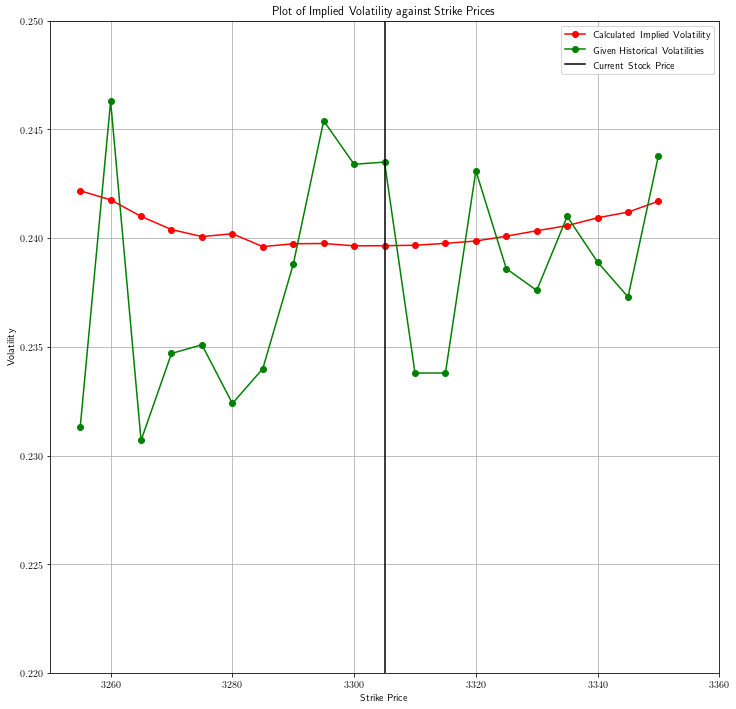

In [98]:
# Initial Data
amzn_stock = 3305.00 
amzn_interest = 0.04 # spot rate for zero coupon bonds
D = date(2021, 2, 19) - date(2021, 2, 9) # date to expiry
amzn_time = D.days/365

# Load data from CSV file
read = csv.reader(open('amzn-options-exp-2021-02-19-monthly-near-the-money-stacked-02-09-2021.csv', 'r'))
data = [row for row in read]

# Pick out data for call options
strikes = [row[0] for row in data if row[-2] == 'Call']
calls = [row[3] for row in data if row[-2] == 'Call'] # using the midpoint of the bid-ask spread
given_ivs = [row[-3] for row in data if row[-2] == 'Call']

# Convert into arrays of floats
strikes = array([float(strikes[i].replace(',','')) for i in range(len(strikes))]) # remove commas
calls = array([float(calls[i]) for i in range(len(calls))])
given_ivs = array([0.01*float(given_ivs[i].replace('%','')) for i in range(len(given_ivs))])# convert from percentage

# Implied volatilities
ivs = [optimize.brentq((lambda iv: calls[i] - black_scholes(amzn_interest, iv, amzn_stock, strikes[i], amzn_time)),0.0000001,1) for i in range(len(strikes))]

# Plotting
fig = plt.figure(figsize=(12,12))
rc('text', usetex=True)

title('Plot of Implied Volatility against Strike Prices')
plot(strikes, ivs, 'ro-', label='Calculated Implied Volatility')
plot(strikes, given_ivs, 'go-', label='Given Volatilities')
xlim([3250,3360])
ylim([0.22,0.25])
xlabel('Strike Price')
ylabel('Volatility')
grid()
axhline(color='gray', zorder=-1)
axvline(color='gray', zorder=-1)
axvline(x=amz_stock, color='black', label='Current Stock Price')
legend()
show()

## Problem 3

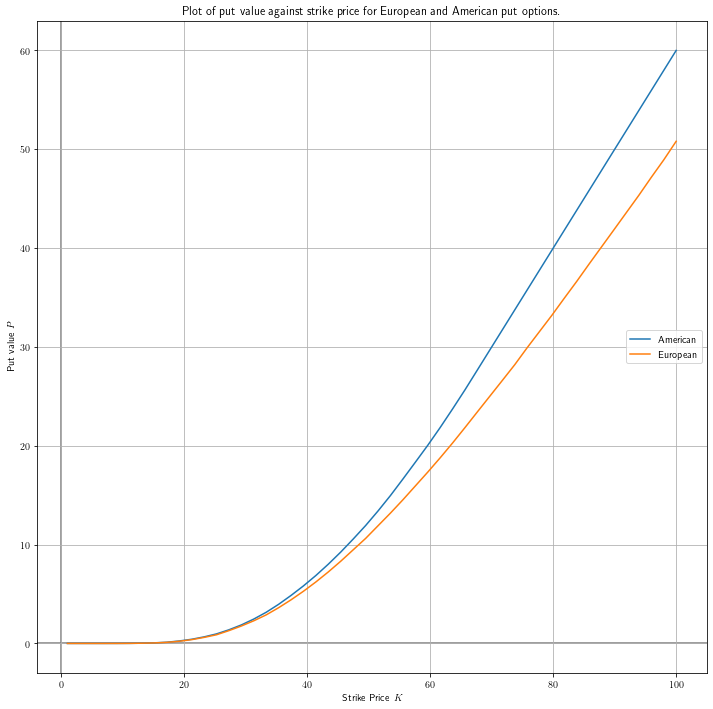

In [99]:
# Initial data
S = 40
K = 45
sigma = 0.5
T = 1
rp = 0.1

def payoff_function(S, K, call_or_put):
    # payoff for single stock price, not vectorized
    if call_or_put == 'call':
        return max(S - K, 0)
    elif call_or_put == 'put':
        return max(K - S, 0)
    else:
        raise Exception("Specify option type: 'call' or 'put'") # reject all other option types
        
payoff = vectorize(payoff_function)

def binomial_tree(payoff, n, rp, sigma, S, K, T, call_or_put, option_type):
    up = exp(sigma*sqrt(T/n))
    down = 1/up
    r = rp*T/n
    p = (exp(r) - down)/(up - down)
    
    S_array = [S*(up**(n-i))*(down**i) for i in arange(0,n+1)]
    C = zeros((n+1, n+1))
    C[:,n] = payoff(S_array, K, call_or_put)
    k = 0
    
    for i in range(n-1, -1, -1): # backward induction
        if option_type == 'American': # compare with early exercise
            C[0:n-k, i] = maximum(e**(-r)*(p*C[0:n-k, i+1] + (1-p)*C[1:n-k+1, i+1]), payoff([S*(up**(i-k))*(down**k) for k in arange(0,i+1)], K, call_or_put))
        elif option_type == 'European':
            C[0:n-k, i] = e**(-r)*(p*C[0:n-k, i+1] + (1-p)*C[1:n-k+1, i+1])
        else:
            raise Exception("Specify option type: 'American' or 'European'") # reject all other option types
        k += 1    
    return C[0,0]

binomial_tree = vectorize(binomial_tree)

KK = linspace(1,100, 50)

fig = plt.figure(figsize=(12,12))
rc('text', usetex=True)

plot(KK, binomial_tree(payoff, 100, rp, sigma, S, KK, T, 'put', 'American'), label='American')
plot(KK, binomial_tree(payoff, 100, rp, sigma, S, KK, T, 'put', 'European'), label='European')
axhline(color='gray', zorder=-1)
axvline(color='gray', zorder=-1)
xlabel(r'Strike Price $K$')
ylabel(r'Put value $P$')
title('Plot of put value against strike price for European and American put options.')
grid()
legend()
show()

All else equal, the price of an American put is higher than that of a European put, reflecting the additional value of the ability to exercise the put early.
## Problem 4

In [116]:
def binomial_tree_full(payoff, n, rp, sigma, S, K, T, call_or_put, option_type):
    up = exp(sigma*sqrt(T/n))
    down = 1/up
    r = rp*T/n
    p = (exp(r) - down)/(up - down)
    
    S_array = [S*(up**(n-i))*(down**i) for i in arange(0,n+1)]
    C = zeros((n+1, n+1))
    C[:,n] = payoff(S_array, K, call_or_put)
    k = 0
    
    for i in range(n-1, -1, -1): # backward induction
        if option_type == 'American':
            C[0:n-k, i] = maximum(e**(-r)*(p*C[0:n-k, i+1] + (1-p)*C[1:n-k+1, i+1]), payoff([S*(up**(i-k))*(down**k) for k in arange(0,i+1)], K, call_or_put))
        elif option_type == 'European':
            C[0:n-k, i] = e**(-r)*(p*C[0:n-k, i+1] + (1-p)*C[1:n-k+1, i+1])
        else:
            raise Exception("Specify option type: 'American' or 'European'") # reject all other option types
        k += 1    
    return C

# Initial data
n = 100
S = 40
K = 45
sigma = 0.5
T = 1
rp = 0.1

CC = binomial_tree_full(payoff, n, rp, sigma, S, K, T, 'put', 'European')

The array `CC[i,j]` indicates the option price after $i$ rises in the stock price in $j$ timesteps. Clearly we must have $i \leq j,$ so we mask the lower diagonal:

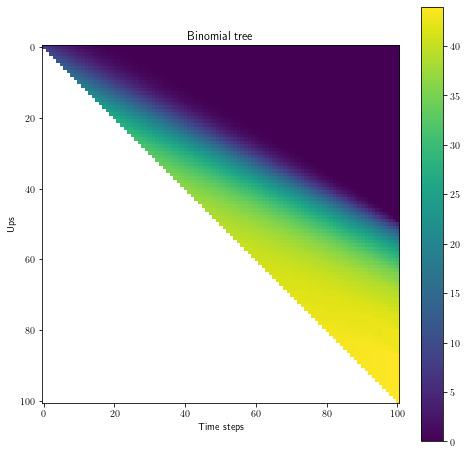

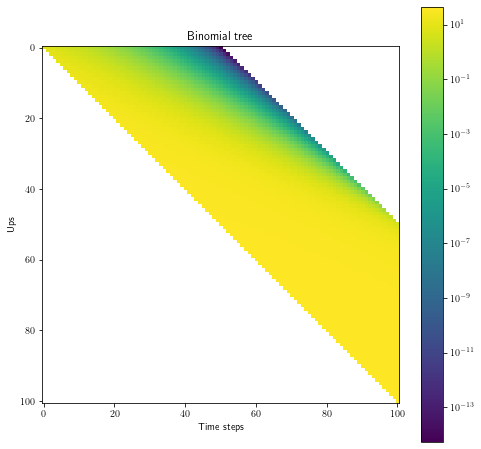

In [117]:
C_mask = ma.masked_array(CC,mask=tril(ones((n+1,n+1)),k=-1)) # mask the entries below leading diagonal

# Plotting
fig1 = plt.figure(figsize=(8,8))
rc('text', usetex=True)

imshow(C_mask)
colorbar()
title('Binomial tree')
xlabel('Time steps')
ylabel('Ups')
show()

fig2 = plt.figure(figsize=(8,8))
rc('text', usetex=True)

imshow(C_mask,norm=matplotlib.colors.LogNorm())
colorbar()
title('Binomial tree')
xlabel('Time steps')
ylabel('Ups')
show()